### Vibrational structure in CO 

In [1]:
# import python packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import math

In [2]:
# functions for loading datasets. the files must be placed in a subfolder
# 'data' in the same directory as the notebook
def dataset_dummy():
    data = np.genfromtxt('./data/dummy_data.txt')
    energy = data[:, 0]
    counts = data[:, 1]
    return energy, counts

def dataset_Ar_3p():
    data = np.genfromtxt('./data/Ar_3p.txt')
    energy = data[:, 0]
    counts = data[:, 1]
    return energy, counts

def dataset_CO_C1s():
    data = np.genfromtxt('./data/CO_C1s.txt')
    energy = data[:, 1]
    counts = data[:, 0]
    return energy, counts
    
def dataset_CO_valence():
    data = np.genfromtxt('./data/CO_valence.txt')
    energy = data[:, 1]
    counts = data[:, 0]
    return energy, counts

In [3]:
# lineshape functions
def gaussian(x, x0, a, fwhm):
    return a * np.exp(-4. * np.log(2) * (x - x0)**2 / fwhm**2)

def lorentzian(x, x0, a, fwhm):
    return a / ((x - x0)**2 + (fwhm/2)**2)

def voigt(x, x0, a, fwhm_l, fwhm_g):
    # evaluate the lorentzian (place it at x0)
    l = lorentzian(x, x0, 1.0, fwhm_l)
    
    # evaluate the gaussian
    g = gaussian(x, np.mean(x), 1.0, fwhm_g)
    
    # convolve the two
    v = np.convolve(l, g, mode='same')
    
    # normalize result, multiply with scaling factor 'a' and return
    return a * v / np.max(v)

def voigt_sum(x, peak_params, same_gaussian_fwhm=False):
    """
    Returns a sum of Voigt profiles defined by the parameters in "peak_params".
    The array "peak_params" has the following structure:
    
    peak_params[0]: position of peak 1
    peak_params[1]: amplitude of peak 1
    peak_params[2]: lorentzian fwhm of peak 1
    peak_params[3]: gaussian fwhm of peak 1
    
    peak_params[4]: position of peak 2
    peak_params[5]: amplitude of peak 2
    peak_params[6]: lorentzian fwhm of peak 2
    peak_params[7]: gaussian fwhm of peak 2
    
    ... etc
    
    peak_params[-1]: constant offset
    
    Thus, the length of peak_params determines the number of voigt profiles.
    If same_gaussian_fwhm is True, all Voigt peaks have the same gaussian fwhm 
    (for example in the case where all peaks are equally affected by instrumental
    broadening) and the structure of peak_params is slightly different:
    
    peak_params[0]: position of peak 1
    peak_params[1]: amplitude of peak 1
    peak_params[2]: lorentzian fwhm of peak 1
    
    peak_params[4]: position of peak 2
    peak_params[5]: amplitude of peak 2
    peak_params[6]: lorentzian fwhm of peak 2
    
    ... etc
    
    peak_params[-2]: gaussian fwhm
    peak_params[-1]: constant offset
    """
    
    # determine the number of peaks
    eps = 1e-10
    if same_gaussian_fwhm:
        npeaks = int((len(peak_params) - 2) / 3 + eps)
        dn = 3
    else:
        npeaks = int((len(peak_params) - 1) / 4 + eps)
        dn = 4
    
    # now 'unwrap' the peak parameters. initialize arrays for position, amplitude, etc
    position = np.zeros(npeaks)
    amplitude = np.zeros(npeaks)
    fwhm_g = np.zeros(npeaks)
    fwhm_l = np.zeros(npeaks)
    
    for ii in range(npeaks):
        position[ii] = peak_params[ii * dn]
        amplitude[ii] = peak_params[ii * dn + 1]
        fwhm_l[ii] = peak_params[ii * dn + 2]
        
        if same_gaussian_fwhm:
            fwhm_g[ii] = peak_params[-2]
        else:
            fwhm_g[ii] = peak_params[ii * dn + 3]
    
    # evaluate the voigt profiles
    y = np.zeros(len(x))
    
    for ii in range(npeaks):
        y += voigt(x, position[ii], amplitude[ii], fwhm_l[ii], fwhm_g[ii])
    
    # add constant offset
    y += peak_params[-1]
    
    # return sum of voigt profiles
    return y
    

In [4]:
# fitting routines
def multipeak_fit_voigt(data_x, data_y, init_guess, same_gaussian_fwhm=False, report_file=None,
                       initial_guess=False):
    """
    function that fits a spectrum with a sum of voigt profiles. data_x contains the x-coordinates of the
    data points (the energy axis in case of a spectrum) and data_y contains the y-values (counts). 
    
    init_guess is a two-dimensional array of size N x 4, where N is the number of voigt peaks
    that should be included in the fit. It holds all parameters that define the starting point for the fit,
    and its structure is as follows:
    
    "peak 1 position", "peak 1 amplitude", "peak 1 lorentzian fwhm", "peak 1 gaussian fwhm"
    "peak 2 position", "peak 2 amplitude", "peak 2 lorentzian fwhm", "peak 2 gaussian fwhm"
    ...
    "peak N position", "peak N amplitude", "peak N lorentzian fwhm", "peak N gaussian fwhm"
    
    If same_gaussian_amplitude is True, all peaks will have the same Gaussian amplitude. In that case,
    the gaussiam fwhm value for the first peak will be used as initial guess and all other values will
    be ignored.
    
    If a filename is passed via the 'report_file' keyword, a fit report with parameter values
    will be written to the specified file.
    """
    
    # create 1d initial guess array that is compatible with the "voigt_sum" function
    npeaks = init_guess.shape[0]
    if same_gaussian_fwhm:
        p0 = np.zeros(npeaks * 3 + 2)
        dn = 3
    else:
        p0 = np.zeros(npeaks * 4 + 1)
        dn = 4
        
    for ii in range(npeaks):
        p0[ii * dn + 0] = init_guess[ii, 0]
        p0[ii * dn + 1] = init_guess[ii, 1]
        p0[ii * dn + 2] = init_guess[ii, 2]
        if not same_gaussian_fwhm:
            p0[ii * dn + 3] = init_guess[ii, 3]
    
    if same_gaussian_fwhm:
        p0[-2] = init_guess[0, 3]
       
    # function for calculating residuals (difference between current fit and data)
    def residuals(p):
        r = data_y - voigt_sum(data_x, p, same_gaussian_fwhm=same_gaussian_fwhm)
        return r
    
    # fit
    if not initial_guess:
        fit_result = opt.least_squares(residuals, p0, method='lm')
        popt = fit_result.x
       
        # print fit results
        fit_report = ''
        fit_report += '# Fit parameters:\n'
        fit_report += '# ---------------\n'
        fit_report += '# peak nr\tposition\tamplitude\tfwhm_l\tfwhm_g\n'
    
        for ii in range(npeaks):
            fit_report += '{:d}\t{:.4f}\t{:.4f}\t{:.4f}\t'.format(ii+1, popt[ii * dn], popt[ii * dn + 1],
                                                              popt[ii * dn + 2])
            if same_gaussian_fwhm:
                fit_report += '{:.4f}\n'.format(abs(popt[-2]))
            else:
                fit_report += '{:.4f}\n'.format(abs(popt[ii * dn + 3]))

        print(fit_report)
    
        if report_file is not None:
            f = open(report_file, 'w+')
            f.write(fit_report)
            f.close()
    
    elif initial_guess:
        popt = p0    
    
    fit = voigt_sum(data_x, popt, same_gaussian_fwhm=same_gaussian_fwhm)
    return fit 
    

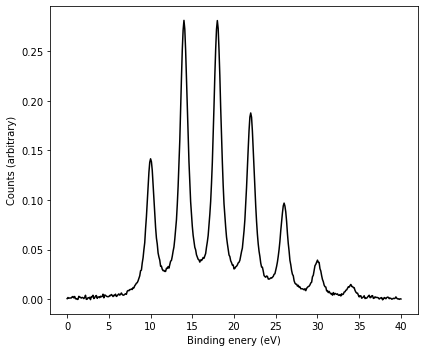

In [5]:
# load dataset
energy, counts = dataset_dummy()
# energy, counts = dataset_Ar_3p()
# energy, counts = dataset_CO_valence()
# energy, counts = dataset_CO_C1s()

# plot the data
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(energy, counts, '-', color='k', fillstyle='none', mew=1)
ax.set_xlabel('Binding enery (eV)')
ax.set_ylabel('Counts (arbitrary)')

plt.tight_layout()
# uncomment next line for saving the plot as png file
# plt.savefig('my_figure.png', dpi=350, bbox_inches='tight', transparent=True)
plt.show()

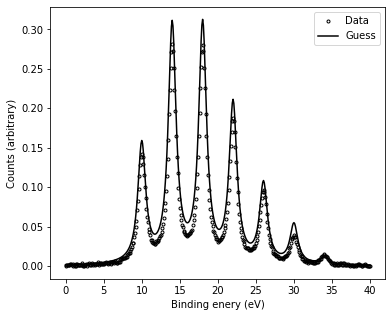

In [8]:
# now set the intial guess for fitting
# each subarray contains the intial parameters for one voigt peak:
# position (in eV), amplitude, lorentzian fwhm and gaussian fwhm.
# to change the number of voigt peaks, add or remove subarrays
init_guess = np.array([[10., 0.15, 1.2, 0.2],  # position, amplitude, fwhm_l and fwhm_g of peak 1
                       [14., 0.3, 1.2, 0.2],   # position, amplitude, fwhm_l and fwhm_g of peak 2
                       [18., 0.3, 1.2, 0.2],
                       [22., 0.2, 1.2, 0.2],
                       [26., 0.1, 1.2, 0.2],
                       [30, 0.05, 1.2, 0.2],
                       [34, 0.01, 1.2, 0.1]])


# evaluate initial guess. with "initial_guess=True", the function only evaluates the initial guess
# but does not perform any fitting
counts_guess = multipeak_fit_voigt(energy, counts, init_guess, same_gaussian_fwhm=False, initial_guess=True)

# plot data and initial guess
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(energy, counts, '.', color='k', fillstyle='none', mew=1, label='Data')
ax.plot(energy, counts_guess, color='k', label='Guess')
ax.set_xlabel('Binding enery (eV)')
ax.set_ylabel('Counts (arbitrary)')
ax.legend()

# Fit parameters:
# ---------------
# peak nr	position	amplitude	fwhm_l	fwhm_g
1	10.0006	0.1355	1.0122	0.3859
2	14.0021	0.2712	1.0082	0.3793
3	18.0006	0.2707	0.9960	0.4036
4	22.0004	0.1799	0.9905	0.4206
5	25.9992	0.0910	1.0080	0.3793
6	30.0013	0.0355	0.9436	0.5092
7	33.9885	0.0121	0.6786	0.7713



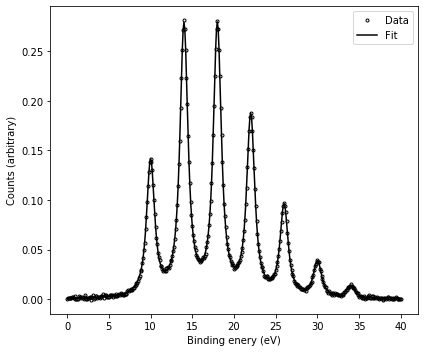

In [9]:
# call the function that fits the data
counts_fit = multipeak_fit_voigt(energy, counts, init_guess, same_gaussian_fwhm=False, report_file='fit_report.txt')

# plot the data
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(energy, counts, '.', color='k', fillstyle='none', mew=1, label='Data')
ax.plot(energy, counts_fit, color='k', label='Fit')
ax.set_xlabel('Binding enery (eV)')
ax.set_ylabel('Counts (arbitrary)')
ax.legend()

plt.tight_layout()
# uncomment next line for saving the plot as png file
# plt.savefig('my_figure.png', dpi=350, bbox_inches='tight', transparent=True)
plt.show()
